# Imports

In [1]:
from typing import List, Tuple
import math

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load the data

In [2]:
def load_data(data_path: str='./') -> pd.DataFrame:
    '''
    Function to load the data
    Params: data_path (type: str, default './')
    Returns: df (type: Pandas DataFrame)
    '''
    df = pd.read_csv(data_path+'Data Science Data - 2020.csv', index_col=4)
    return df

In [3]:
#load data, print shape, print info, and see head of data
df = load_data()
print('Shape of data: {}'.format(df.shape))
print(df.info())
df.head()

Shape of data: (82, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         82 non-null     object 
 1   amount       82 non-null     float64
 2   description  82 non-null     object 
 3   class        82 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ KB
None


,date,amount,description,class
id,,,,
0,2019-01-17,-1.41,tfl travel ch,2
1,2019-02-06,-23.83,curtains up,2
2,2019-01-08,-14.50,co-op group food,2
3,2019-02-03,-8.52,boots 631,1
4,2019-01-05,-15.57,sumup *proceed cl,2


# Change the date from dtype 'object' to 'datetime'

In [4]:
def fix_date_type(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Function to change the dtype of the date from 'object' to 'datetime'
    Params: df (type: Pandas DataFrame)
    Returns: df (type: Pandas DataFrame)
    '''
    df.date = pd.to_datetime(df.date)
    return df

In [5]:
#change date from dtype object to datetime
df = fix_date_type(df)

# EDA

Let's have a look at the data to get a better understanding of how it all fits together. This will hopefully give us clues about how the data should be modelled and a clearer way to evaluate generated samples.

In [6]:
df.describe()

,amount,class
count,82.000000,82.000000
mean,-38.193049,0.902439
std,161.520429,0.795198
min,-1443.060000,0.000000
25%,-24.220000,0.000000
50%,-9.045000,1.000000
75%,-3.297500,2.000000
max,39.180000,2.000000


## Missing Data

**GOOD:** there is no missing data in the sample we have been given

In [7]:
df.isnull().sum()

date           0
amount         0
description    0
class          0
dtype: int64

## Date

* The data spans the dates from 01/01/2019 until 13/02/2019.
* There is no obvious pattern in the number of samples at each date, except a possible very slight increase as time goes on, but its marginal at best.

**THOUGHTS:** maybe its worth normalising so that new data can be generated at a dates relative to the frequency they appear in the observed sample

,num_samples
date,
2019-01-01,2
2019-01-02,2
2019-01-03,1
2019-01-04,3
2019-01-05,2
2019-01-06,2
2019-01-07,3
2019-01-08,1
2019-01-09,1


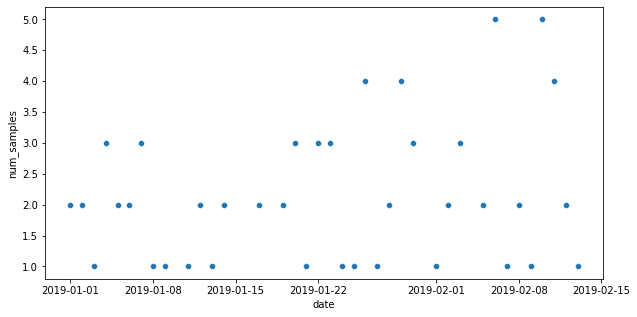

In [8]:
#groupby date to see number of samples per day
date_groups = df.groupby('date').size().to_frame(name='num_samples').sort_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=date_groups.index, y=date_groups.num_samples)

date_groups.head(10)

## Class

It's always worth checking whether the classes are balanced in these types of data sets.

**GOOD:** the classes are well balanced

In [9]:
#number of samples per class
df['class'].value_counts()

1    30
0    30
2    22
Name: class, dtype: int64

## Description

The description variable looks to be the most challenging to work with since its text. Furthermore:
* Every description is unqiue, there are 82 different descriptions across the 82 observed samples
* Depending on how we decide to move forward with the descriptions, they could require a fair amount pre-processing. For example, if we want to use word embeddings to capture the meaning of words then symbols like '*', or '/' might need to go. However, word embeddings might not be the way to go given that these descriptions are primarily company names. This is made harder by certain samples being related to the same company but described very differently, for example, 'amzn mktp uk' and 'amazon.co.uk'.

**THOGUHT:** these descriptions are going to be encoded into dense representations of a smaller dimension.

In [10]:
df.description.unique()

array(['tfl travel ch', 'curtains up', 'co-op group food', 'boots 631',
       'sumup  *proceed cl', 'arepa & co', 'iz *parmstar',
       'sainsburys s mkts', 'yorkshire grey', 'iz *the hive',
       'spotify xy480u480o480', 'gb25  spitalfie', 'simply fresh',
       'caffe nero', 'gb663  oxford st', 'uber eats xy618u618o618 he',
       'lnk po roman road', 'netflix.com', 'waitrose', 'boots 759',
       'lidl uk  london', 'lidl uk london', 'three-topup(web)',
       'downland produce', 'la bouche', 'revolut*445*',
       'the horn of plenty', 'the camel', 'taro restaurant',
       'aint nothin but', 'giraffe concepts l', 'bunbun bun',
       'hoxton cabin', 'lnk 0-0 cambri', 'greater anglia - s',
       'amazon.co.uk', 'amzn mktp uk', 'sainsburys s/mkts',
       'tfx international', 'uber eats rotzz he', 'franco manca',
       'red lion', 'moneyfarm', 'boots787', 'boots 133',
       'easyjet     xy400u400o400', 'the draft house bi',
       'lnk costcutter480', 'iz *kansas smitty?', 'ike

### Description per Class

**NOTE:** this raises the question as to whether the classes were built to categorise certain samples by their description.
* I couldn't spot any obvious patterns in the descriptions. For example, I noticed that:
    * Supermarket related descriptions were present in all three classes: class 0 had 'sainsburys s mkts', class 1 had 'tesco store 776', and class 2 had 'co-op group food'
    * Online services related descriptions were present in all three classes: class 0 had 'netflix.com', class 1 had 'spotify xy480u480o480', and class 2 had 'three-topup(web)'
    * Travel related descriptions were present in all three classes: class 0 had 'easyjet     xy400u400o400', class 1 had 'eurowings   37', and class 2 had 'tfl travel ch'
    * Retailer related descriptions were present in all three classes: class 0 had 'boots989', class 1 had 'uniqlo (europe) lt', and class 2 had 'tfl travel ch'

In [11]:
class_dscrpt = df.groupby('class')['description'].unique()
for i in range(0,3):
    print('Looking at class": {} \n {} \n'.format(i, class_dscrpt[i]))

Looking at class": 0 
 ['iz *parmstar' 'sainsburys s mkts' 'caffe nero'
 'uber eats xy618u618o618 he' 'lnk po roman road' 'netflix.com'
 'boots 759' 'la bouche' 'bunbun bun' 'hoxton cabin' 'sainsburys s/mkts'
 'tfx international' 'red lion' 'boots787' 'boots 133'
 'easyjet     xy400u400o400' 'the draft house bi' 'lnk costcutter480'
 'iz *kansas smitty?' 'boots989' 'prince albert' 'well & bucket' 'loafing'
 'thai room (london)' 'lnk angel convenie' 'barbican cntre box'
 'monohon ramen' 'the haggerston' 'the royal oak' 'tesco stores-856'] 

Looking at class": 1 
 ['boots 631' 'spotify xy480u480o480' 'gb25  spitalfie' 'lidl uk  london'
 'downland produce' 'revolut*445*' 'aint nothin but' 'giraffe concepts l'
 'greater anglia - s' 'amazon.co.uk' 'amzn mktp uk' 'uber eats rotzz he'
 'franco manca' 'moneyfarm' 'ikea limited' 'boundary rooftop'
 'easyjet     9' 'tezenis oxford cir' 'uniqlo (europe) lt' 'monzo top up'
 'mudmee thai restau' 'trade' 'sager and wilde' 'eurowings   37'
 'leongs le

## Amount

A density plot of the amount (and split by class) reveals that the distribution of amount follows a similar shape across all the classes, with each centered just below 0 and having a smaller second peak towards the left tail. However, it is worth noting that class 1 has a much larger spread than the other classses, which I suspect is also leading to the large spread in the density plot for all classes combined.

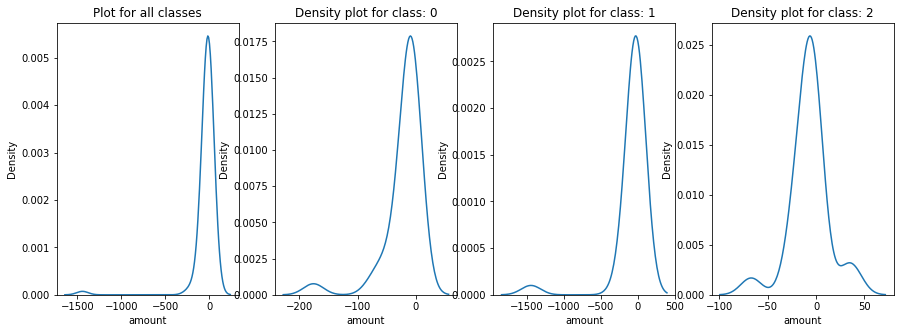

In [12]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,5))
sns.kdeplot(x='amount', data=df, ax=ax[0])
ax[0].title.set_text('Plot for all classes')
for i in range(0,3):
    ax[i+1].title.set_text('Density plot for class: {}'.format(i))
    sns.kdeplot(x='amount', data=df[df['class']==i], ax=ax[i+1])

### Amount over time

Overall, the amount variable is fairly stable over time for, as a whole and for each class individually.

**NOTICE:** towards the end of January one observed sample from class 1 had a very large negative amount value. This is most likely an outlier, but it might also be something seasonal about class 1 and we just don't have enough data to see the trend properly. What I mean by seasonality are things like monthly payments from employers (debit) or payments towards rent (credit). On closer inspection, it looks like nergative amounts are credits, so I this large negative amount could be someone paying rent. I plot a boxplot below for the amount, and split by class, to look at the values, which helps to see how far away the sample is away from the rest of the sample points. My assumption here is that it is an outlier and that is how I will proceed.

<AxesSubplot:title={'center':'Scatterplot of amount over time, by class'}, xlabel='date', ylabel='amount'>

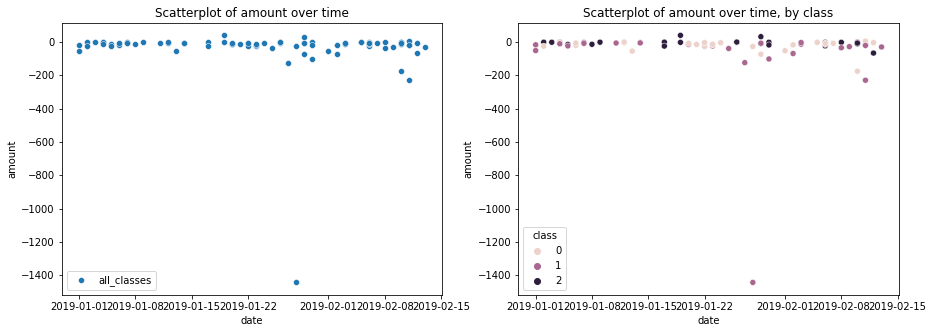

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
ax[0].title.set_text('Scatterplot of amount over time')
sns.scatterplot(x='date', y='amount', data=df, label='all_classes', ax=ax[0])
ax[1].title.set_text('Scatterplot of amount over time, by class')
sns.scatterplot(x='date', y='amount', hue='class', data=df, ax=ax[1])

<AxesSubplot:title={'center':'Boxplot of amount, by class'}, xlabel='class', ylabel='amount'>

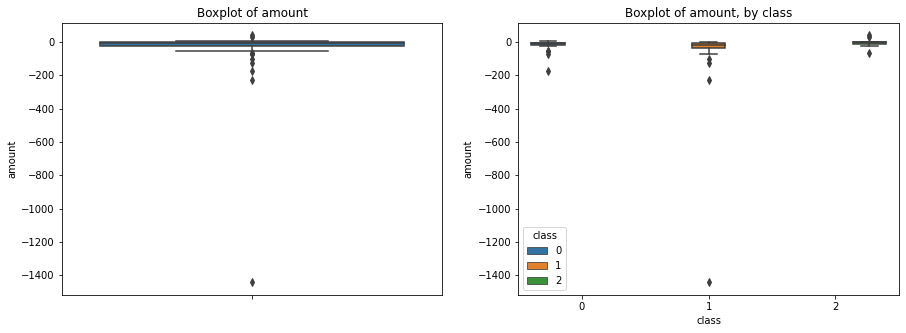

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
ax[0].title.set_text('Boxplot of amount')
sns.boxplot(y='amount', data=df, ax=ax[0])
ax[1].title.set_text('Boxplot of amount, by class')
sns.boxplot(x='class', y='amount', hue='class', data=df, ax=ax[1])

### Dropping the potential outlier in class 1

**NOTICE:** The drop of that one point makes the distributions of all the classes much more alike - although each class still has a different spread.

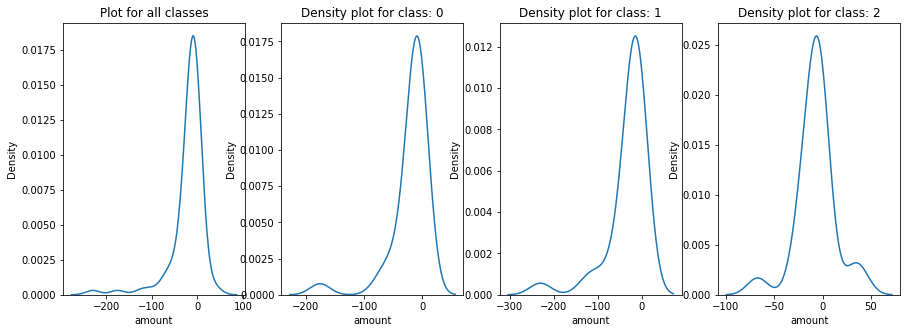

In [15]:
c1_outlier_val = df[df['class']==1]['amount'].min()
tmp_df = df[df['amount']!=c1_outlier_val]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,5))
sns.kdeplot(x='amount', data=tmp_df, ax=ax[0])
ax[0].title.set_text('Plot for all classes')
for i in range(0,3):
    ax[i+1].title.set_text('Density plot for class: {}'.format(i))
    sns.kdeplot(x='amount', data=tmp_df[tmp_df['class']==i], ax=ax[i+1])

 # Generator A - Power Transformations

One idea is to apply a power transformation to the amount variable to make it close to a Normal distribution - this could be done for each class seperately. From here we could then draw samples from the normal distribution and do the inverse transformation to get back a sample from the original amount distribution.

## Proof of Concept

**GOOD AND BAD NEWS:** this doesnt work very well. I performed a KS-test on the original distribution and the synthetic distribution to test whether (alternate hypotehsis) that the two samples are drawn from different distributions. When looking at all classes, the KS-test gave a p-value of <0.01 and so we should reject the null hypothesis, implying that the samples came from different distributions. However, when we performed the KS-test on each classes' original and synthetic distributions we saw the p-values are much larger (>0.05 for example) and so we cannot reject the null hypothesis here, implying the samples came from the same distribution.

**NOTE:** this has given some mixed results. On a class by class basis this method does a fairly good job, but its not amazing when applied over all the classes. However, this might be the very reason for these samples being labelled as different classes - which I haven't got a way to confirm. Either way I suspect this method can be greatly improved by having more data.

**NOTE:** the outlier in class 1 makes the syntehtic distribution look bad. I'm sure if it was removed it would help too. I will leave this for now, but I'm noting it.

KS-test of original and synthetic distribution of amount for all classes: KstestResult(statistic=0.31441463414634147, pvalue=3.748237885625727e-07)
KS-test of original and synthetic distribution of amount for class 0: KstestResult(statistic=0.16466666666666666, pvalue=0.36809875550337634)
KS-test of original and synthetic distribution of amount for class 1: KstestResult(statistic=0.079, pvalue=0.9866411465367101)
KS-test of original and synthetic distribution of amount for class 2: KstestResult(statistic=0.2570909090909091, pvalue=0.09623526468444188)


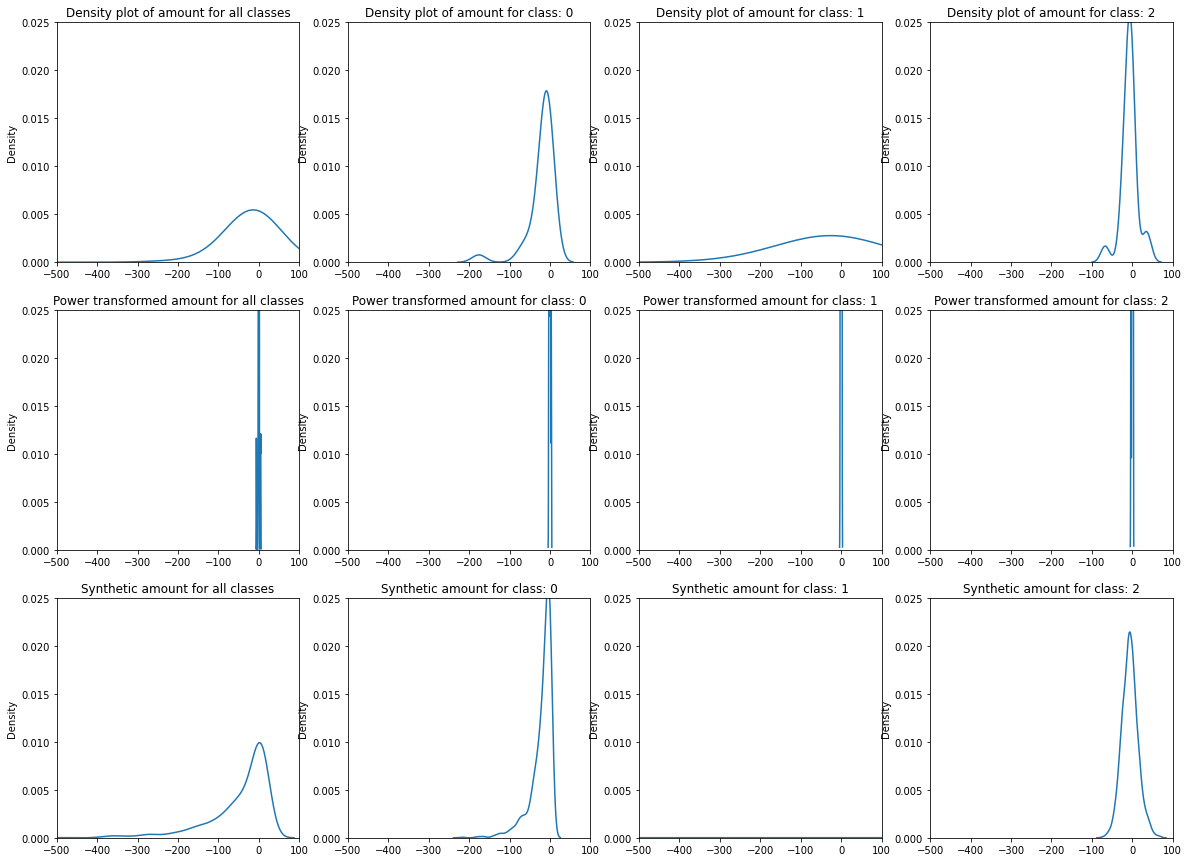

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,15))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-500, 100)
custom_ylim = (0, 0.025)
# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

#original amount
a = df['amount'].to_numpy().reshape(-1,1)
sns.kdeplot(x=a.reshape(-1), ax=ax[0,0])
ax[0,0].title.set_text('Density plot of amount for all classes')

#power transformed amount
pt = PowerTransformer().fit(a)
sns.kdeplot(x=pt.transform(a).reshape(-1), ax=ax[1,0])
ax[1,0].title.set_text('Power transformed amount for all classes')

#synthetic amount
sns.kdeplot(x=pt.inverse_transform(np.random.normal(size=(1000,1))).reshape(-1), ax=ax[2,0])
ax[2,0].title.set_text('Synthetic amount for all classes')

pwr_tr = {}
for i in range(0,3):
    #original amount
    tmp_a = df[df['class']==i]['amount'].to_numpy().reshape(-1,1)
    sns.kdeplot(x=tmp_a.reshape(-1), ax=ax[0,i+1])
    ax[0,i+1].title.set_text('Density plot of amount for class: {}'.format(i))
    
    #power transformed amount
    pwr_tr[i] = PowerTransformer().fit(tmp_a)
    sns.kdeplot(x=pwr_tr[i].transform(tmp_a).reshape(-1), ax=ax[1,i+1])
    ax[1,i+1].title.set_text('Power transformed amount for class: {}'.format(i))
    
    #synthetic amount
    sns.kdeplot(x=pwr_tr[i].inverse_transform(np.random.normal(size=(1000,1))).reshape(-1), ax=ax[2,i+1])
    ax[2,i+1].title.set_text('Synthetic amount for class: {}'.format(i))
    

a = df['amount'].to_numpy().reshape(-1,1)
print('KS-test of original and synthetic distribution of amount for all classes: {}'.format(ks_2samp(a.reshape(-1),pt.inverse_transform(np.random.normal(size=(1000,1))).reshape(-1))))
for i in range(0,3):
    tmp_a = df[df['class']==i]['amount'].to_numpy().reshape(-1,1)
    print('KS-test of original and synthetic distribution of amount for class {}: {}'.format(i,ks_2samp(tmp_a.reshape(-1),pwr_tr[i].inverse_transform(np.random.normal(size=(1000,1))).reshape(-1))))

## Generate new data from Power Transformations

In [17]:
BATCH_SIZE = 5
batch_df = df.sample(n=BATCH_SIZE)
batch_df.head()

,date,amount,description,class
id,,,,
28,2019-01-17,-25.19,taro restaurant,2
34,2019-02-03,-13.49,greater anglia - s,1
41,2019-02-07,-8.40,red lion,0
26,2019-01-30,-2.19,the horn of plenty,2
57,2019-02-10,-1.60,uniqlo (europe) lt,1


In [18]:
def generate_from_PT(batch_size: int, df: pd.DataFrame) -> pd.DataFrame:
    for i in range(len(batch_df)):
        class_num = batch_df['class'].iloc[i]
        batch_df.amount.iloc[i] = pwr_tr[class_num].inverse_transform(np.random.normal(size=(1,1))).reshape(-1)[0]
    return batch_df

In [19]:
batch_df = generate_from_PT(batch_size=BATCH_SIZE, df=batch_df)
batch_df.head()

,date,amount,description,class
id,,,,
28,2019-01-17,-2.713621,taro restaurant,2
34,2019-02-03,-16.628335,greater anglia - s,1
41,2019-02-07,-14.673102,red lion,0
26,2019-01-30,-15.940101,the horn of plenty,2
57,2019-02-10,-14.053095,uniqlo (europe) lt,1


# Generator B - GAN

Let's get our hands dirty with some deep learning. Basic overview:

1. Encode descriptions into lower dimensional embedding space.
2. Train GAN (generator and discriminator) to learn the features amount and description together
3. Generate new synthetic samples of the amount and description features.

## Tabular Dataset Class

This will make it easier for training our description encoder, and our GAN models later

In [20]:
class TabularDataset(Dataset):
    def __init__(self, df):
        super(TabularDataset, self).__init__()
        self.X_weekday, self.X_month = self.get_date(df.date)
        self.X_amount = torch.FloatTensor(df.amount)
        self.X_description = df.description
        self.X_description_labels = self.encode_descriptions(self.X_description)
        self.idx2desc_dict = self.idx2desc(df.description)
        self.y = torch.LongTensor(df['class'])

    def get_date(self, X_date):
        '''
        Function to split datetime into weekday (0 to 6) and month (1 to 12)
        '''
        weekday = torch.LongTensor(X_date.dt.weekday.to_numpy())
        month = torch.LongTensor(X_date.dt.month.to_numpy())
        return weekday, month

    def encode_descriptions(self, X_description):
        '''
        Function to 
        '''
        le = preprocessing.LabelEncoder()
        X_description_labels = torch.LongTensor(le.fit_transform(X_description))
        return X_description_labels
    
    def idx2desc(self, X_description):
        '''
        Functiont to
        '''
        idx2desc_dict = {}
        for i,desc in enumerate(X_description):
            idx2desc_dict[i] = desc
        return idx2desc_dict
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.X_weekday[idx], self.X_month[idx], self.X_amount[idx], self.X_description_labels[idx]), self.y[idx]

## Encode Descriptions

In [21]:
class DescriptionEncoder(nn.Module):
    def __init__(self, desc_embedding_size, desc_embedding_dim, desc_embedding_dropout, dropout, n_classes):
        super(DescriptionEncoder, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=desc_embedding_size, embedding_dim=desc_embedding_dim)
        self.embedding_dropout = nn.Dropout(p=desc_embedding_dropout)

        self.net = nn.Sequential(
            nn.Linear(desc_embedding_dim, 50),
            nn.LeakyReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(p=dropout),
            nn.Linear(50,50),
            nn.LeakyReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(p=dropout),
            nn.Linear(50,n_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = self.net(x)
        return x

In [22]:
def train_encoder(encoder, criterion, optimizer, X, y):
    '''
    Function to train the encoder
    Params: encoder (type: ), criterion (type: ), optimizer (type: ),
            X (type: torch.Tensor), y(type: torch.Tensor)
    Returns: loss (type: )
    '''
    encoder.train()
    #zero the gradients
    optimizer.zero_grad()
    #forward pass
    outputs = desc_encoder(X)
    #calculate loss
    loss = criterion(outputs, y.long())
    #backprop
    loss.backward()
    #update params
    optimizer.step()
    return loss.item()

def eval_encoder(encoder, criterion, X, y):
    '''
    Function to evaluate encoder performance

    Returns: loss ()
    '''
    encoder.eval()
    outputs = desc_encoder(X)
    loss = criterion(outputs, y.long())
    return loss.item()

### Train Description Encoder

I'll use a test set to monitor generalisation performance.

In [23]:
train_df, test_df = train_test_split(df, test_size=0.15)
print(train_df.shape, test_df.shape)

(69, 4) (13, 4)


In [24]:
BATCH_SIZE = 8
train_dataset = TabularDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TabularDataset(train_df)
test_loader = DataLoader(train_dataset, batch_size=len(test_dataset), shuffle=False)

Training on:  cuda
----------------------------------------------------------------------------------------------------
Epoch: 0 	 Training Loss: 1.4374333752526178 	 Test Loss: 1.066313624382019
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 50 	 Training Loss: 0.33522676097022164 	 Test Loss: 0.0923873633146286
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 100 	 Training Loss: 0.12677560249964398 	 Test Loss: 0.021836550906300545
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 150 	 Training Loss: 0.0623977

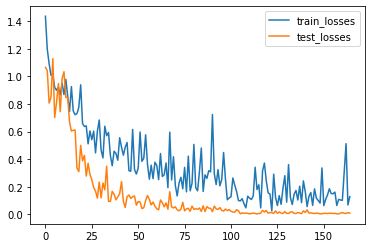

In [25]:
# utilising the gpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on: ', device)

DESC_EMBEDDING_SIZE = df.description.nunique()
DESC_EMBEDDING_DIM = int(math.sqrt(DESC_EMBEDDING_SIZE))
DESC_EMBEDDING_DROPOUT = 0.2
DROPOUT = 0.2
N_CLASSES = df['class'].nunique()

desc_encoder = DescriptionEncoder(
    desc_embedding_size=DESC_EMBEDDING_SIZE,
    desc_embedding_dim=DESC_EMBEDDING_DIM,
    desc_embedding_dropout=DESC_EMBEDDING_DROPOUT,
    dropout=DROPOUT,
    n_classes=N_CLASSES).to(device)

#cross-entropy loss
criterion_desc_encoder = nn.CrossEntropyLoss().to(device)

#Adam optimizer
LEARNING_RATE = 0.01
optimizer_desc_encoder = optim.Adam(desc_encoder.parameters(), lr=LEARNING_RATE)

#training params
MAX_EPOCHS = 500
PATIENCE = 50

#arrays to save train and test losses
train_losses = np.array([])
test_losses = np.array([])

#track best loss and model params
best_loss = np.inf
best_desc_encoder_dict = {}


#TRAINING DESCRIPTION EMBEDDINGS/ ENCODER
for epoch in range(MAX_EPOCHS):
    train_loss = 0
    for (_,_,_,X_batch),y_batch in train_loader:
        #send batch to device
        X_batch,y_batch = X_batch.to(device),y_batch.to(device)
        #train model and get loss
        train_loss += train_encoder(
            encoder=desc_encoder,
            criterion=criterion_desc_encoder,
            optimizer=optimizer_desc_encoder,
            X=X_batch,
            y=y_batch) / len(train_loader)
    #save training loss
    train_losses = np.append(train_losses, train_loss)

    #TEST
    (_,_,_,X_test),y_test = next(iter(test_loader))
    test_loss = eval_encoder(
        encoder=desc_encoder,
        criterion=criterion_desc_encoder,
        X=X_batch,
        y=y_batch
        ) / len(test_loader)
    #save test loss
    test_losses = np.append(test_losses, test_loss)

    #printing to watch training
    if epoch%50==0:
        print('-'*100)
        print('Epoch: {} \t Training Loss: {} \t Test Loss: {}'.format(epoch,train_loss,test_loss))
        print('-'*100)

    #tracking best model params
    if test_loss < best_loss:
        best_loss = test_loss
        best_desc_encoder_dict = desc_encoder.state_dict()

    #early stopping
    if epoch>PATIENCE:
        if (best_loss < test_losses[-PATIENCE:]).all():
            print('Early stopping kicked in: Converged')
            break
    

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

# Look at the learned description embeddings

In [26]:
desc_embedding_weight = best_desc_encoder_dict['embedding.weight'].cpu()
desc_embedding = nn.Embedding.from_pretrained(desc_embedding_weight)

print('Embedding for description <{}> is {}'.format(df.description.iloc[0], desc_embedding_weight[0]))

Embedding for description <tfl travel ch> is tensor([ 1.0122,  2.0335,  0.5413, -1.3713,  1.1978, -0.1544, -0.3353,  1.4979,
         0.5411])


## GAN

I won't use a test dataset here.

In [27]:
class NetGenerator(nn.Module):
    '''Class for the generator in the GAN model'''

    def __init__(self):
        super(NetGenerator, self).__init__()
        #define the neural net
        self.net = nn.Sequential(
            nn.Linear(20,32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.Linear(32,32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.Linear(32,10)
            )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.net(z)
        return x

In [28]:
class NetDiscriminator(nn.Module):
    '''Class for the discriminator in the GAN model'''
    
    def __init__(self):
        super(NetDiscriminator, self).__init__()
        #define the neural net
        self.net = nn.Sequential(
            nn.Linear(10,32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.Linear(32,32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.Linear(32,1),
            nn.Sigmoid()
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        return x

In [29]:
def sample_latent_space(batch_size: int) -> torch.Tensor:
    '''
    Function to sample from the latent space, with dimension 20
    Params: batch_size (type: int)
    Returns: z (type: torch.Tensor)
    '''
    z = torch.rand(batch_size, 20)
    return z


def train_discriminator(batch_size: int, generator: NetGenerator, discriminator: NetDiscriminator,
                        discriminator_criterion: torch.nn.modules.loss, discriminator_optimizer: torch.optim,
                        real_X: torch.Tensor, device:torch.device) -> np.float64:
    '''
    Function to train the discriminator in the GAN model
    Params: batch_size (type: int), generator (type: NetGenerator), generator (type: NetDiscriminator),
            generator_criterion (type: torch.nn.modules.loss), generator_optimizer (type: torch.optim),
            device (type: torch.device)
    Returns: loss (type: np.float64
    '''
    #TRAINING THE DISCRIMINATOR
    discriminator.train()
    generator.eval()

    #discriminator makes predictions from the real batch of data
    discriminator_real_outputs = discriminator(real_X)

    #calculate the discriminator loss from the real batch of data
    one_labels = torch.ones(size=(len(discriminator_real_outputs),1)).to(device)
    discriminator_real_loss = discriminator_criterion(discriminator_real_outputs, one_labels)
    discriminator_real_loss.backward()

    #sample some noise
    z_sample = sample_latent_space(batch_size=BATCH_SIZE).to(device)

    #generate a fake batch of data from the noise
    fake_X = generator(z_sample).detach().squeeze(1)

    #make discriminator predictions from the fake batch of data
    discriminator_fake_outputs = discriminator(fake_X)

    #calculate the loss from the fake batch
    zero_labels = torch.zeros(size=(len(discriminator_fake_outputs),1)).to(device)
    discriminator_fake_loss = discriminator_criterion(discriminator_fake_outputs, zero_labels)
    discriminator_fake_loss.backward()
    
    #update the discriminator params
    discriminator_optimizer.step()

    return discriminator_real_loss.item() + discriminator_fake_loss.item()



def train_generator(batch_size: int, discriminator: NetDiscriminator, generator: NetGenerator,
                    generator_criterion: torch.nn.modules.loss, generator_optimizer: torch.optim,
                    device: torch.device) -> np.float64:
    '''
    Function to train the generator in the GAN model
    Params: batch_size (type: int), discriminator (type: NetDiscriminator), generator (type: NetGenerator),
            generator_criterion (type: torch.nn.modules.loss), generator_optimizer (type: torch.optim),
            device (type: torch.device)
    Returns: loss (type: np.float64)
    '''
    #TRAINING THE GENERATOR
    discriminator.eval()
    generator.train()

    #zero the generator gradients
    generator_optimizer.zero_grad()

    #sample some noise
    z_sample = sample_latent_space(batch_size=batch_size).to(device)

    #generate a fake batch of data from the noise
    generator_outputs = generator(z_sample).squeeze(1)

    #make discriminator predictions from the fake batch of data
    discriminator_gen_outputs = discriminator(generator_outputs)

    #compute generator loss
    one_labels = torch.zeros(size=(len(discriminator_gen_outputs),1)).to(device)
    generator_loss = generator_criterion(discriminator_gen_outputs, one_labels)
    generator_loss.backward()
    
    #update the generator params
    generator_optimizer.step()

    return generator_loss.item()

In [30]:
def custom_collate_fn(batch) -> Tuple[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]:
    '''
    Function to customise the batching of the data
    This allows the X_description_labels to be embedded on the fly
    Params: batch
    Returns: (X_weekday (type: torch.Tensor), X_month (type: torch.Tensor), X_amount (type: torch.Tensor), X_description_emb(torch.Tensor)), y (type: torch.Tensor)
    '''
    X_weekday = torch.FloatTensor([item[0][0] for item in batch])
    X_month = torch.FloatTensor([item[0][1] for item in batch])
    X_amount = torch.FloatTensor([item[0][2] for item in batch])
    X_description_emb = torch.stack([desc_embedding(item[0][3]) for item in batch], axis=0)
    y = torch.LongTensor([item[1] for item in batch])
    return (X_weekday, X_month, X_amount,X_description_emb), y

BATCH_SIZE = 8
gan_dataset = TabularDataset(df)
gan_loader = DataLoader(gan_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, shuffle=True)

#test_dataset = TabularDataset(test_df)
#test_loader = DataLoader(train_dataset, batch_size=len(test_dataset), shuffle=False)

Training on:  cuda
----------------------------------------------------------------------------------------------------
Epoch: 0 	 Discriminator Loss: 0.16108116176393297 	 Generator Loss: 0.056307196617126465
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 50 	 Discriminator Loss: 0.16398084163665771 	 Generator Loss: 0.019483124216397602
----------------------------------------------------------------------------------------------------
Early stopping kicked in: Converged


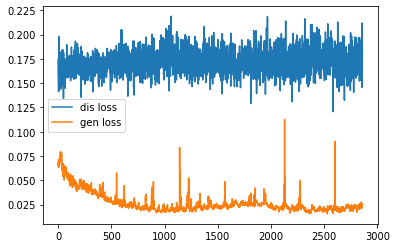

In [31]:
# utilising the gpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on: ', device)

#hyperparams
LEARNING_RATE = 0.0001

#generator
net_gen = NetGenerator().to(device)
criterion_gen = nn.BCELoss().to(device)
optimizer_gen = optim.Adam(net_gen.parameters(), lr=LEARNING_RATE)

#discriminator
net_dis = NetDiscriminator().to(device)
criterion_dis = nn.BCELoss().to(device)
optimizer_dis = optim.Adam(net_dis.parameters(), lr=LEARNING_RATE)

#training params
MAX_EPOCHS = 500
D_STEPS = 5
G_STEPS = 5
PATIENCE = 50

#arrays to save dis and gen losses
dis_losses = np.array([])
gen_losses = np.array([])

#track best gen loss and model params
best_gen_loss = np.inf
best_gen_dict = {}

#TRAINING THE GAN MODELS
for epoch in range(0,MAX_EPOCHS):
    for (_,_,X_amount_batch,X_description_labels_batch),_ in gan_loader:
        X_amount_batch = X_amount_batch.to(device)
        X_description_labels_batch = X_description_labels_batch.to(device)
        X_batch = torch.cat([X_amount_batch.view(-1,1),X_description_labels_batch], axis=1)

        #TRAIN DISCRIMINATOR
        for d_step in range(D_STEPS):
            
            dis_loss = train_discriminator(batch_size=BATCH_SIZE,
                                            generator=net_gen,
                                            discriminator=net_dis,
                                            discriminator_criterion=criterion_dis,
                                            discriminator_optimizer=optimizer_dis,
                                            real_X=X_batch,
                                            device=device
                                            ) /len(train_loader)
            #save discriminator loss
            dis_losses = np.append(dis_losses, dis_loss)
        
        #TRAIN GENERATOR
        for g_step in range(G_STEPS):
            gen_loss = train_generator(batch_size=BATCH_SIZE,
                                        discriminator=net_dis,
                                        generator=net_gen,
                                        generator_criterion=criterion_gen,
                                        generator_optimizer=optimizer_gen,
                                        device=device
                                        ) /len(train_loader)
            #save generator loss
            gen_losses = np.append(gen_losses, gen_loss)

    #printing to watch training
    if epoch%50==0:
        print('-'*100)
        print('Epoch: {} \t Discriminator Loss: {} \t Generator Loss: {}'.format(epoch,dis_loss, gen_loss))
        print('-'*100)

    #tracking best model params
    if gen_loss < best_gen_loss:
        best_gen_loss = gen_loss
        best_gen_dict = net_gen.state_dict()

    #early stopping
    if epoch > PATIENCE:
        if (best_loss < gen_losses[-PATIENCE:]).all():
            print('Early stopping kicked in: Converged')
            break

#load best generator model
net_gen.load_state_dict(best_gen_dict)

plt.plot(dis_losses, label='dis loss')
plt.plot(gen_losses, label='gen loss')
plt.legend()

## Generate new data from GAN

I will sample from the latent space, send it throught the generator from the GAN model, then split the generated feature vector into a generated amount feature (at index 0) and a generated description encoding (index 1 to 9).

I will then compute a similiarty computation using the dot product to find the description embedding that is most similiar to the generated description encoding.

In [32]:
def decode_sample(fake_X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Function to decode the generated sample from the GAN
    Split the data into amount (index 0) and the description embedded (index 1 to 9)
    Params: fake_X (type: torch.Tensor)
    Returns: X_amount (type: torch.Tensor), X_description_emb (type: torch.Tensor)
    '''
    fake_X_amount = fake_X[:,0]
    fake_X_description_emb = fake_X[:,1:]
    return fake_X_amount, fake_X_description_emb


def get_most_similar_embd_idx(embedding_weights: torch.Tensor, X_embedding: torch.Tensor) -> List[torch.Tensor]:
    '''
    Function to get index of the most similiar word embedding
    Uses the dot product to calculate the most similiar word embedding.
    Params: embedding_weights (type: torch.Tensor), X_embedding (type: torch.Tensor)
    Returns: most_sim_idx (type: List[torch.Tensor])
    '''
    l2_norm_embedding_weights = torch.norm(embedding_weights, dim=1)
    normalised_embedding_weights = (1 /l2_norm_embedding_weights) * embedding_weights.T

    l2_norm_X_embeddings = torch.norm(X_embedding, dim=1)
    normalised_X_embeddings = (1 /l2_norm_X_embeddings) * X_embedding.T
    
    sim = torch.matmul(normalised_X_embeddings.T, normalised_embedding_weights)

    most_sim_idx = list(np.argmax(sim, axis=1))
    return most_sim_idx


def decode_desc_embeddings(most_sim_emb_idx: torch.Tensor, model_Dataset: torch.utils.data.Dataset) -> List[str]:
    '''
    Function to retrieve test description from the most similar embedding index
    Calls on the idx2desc dictionary which was created in the model_Dataset initialisation
    Params: most_sim_emb_idx (type: torch.Tensor), model_dataset (type: torch.utils.Dataset)
    Returns: fake_X_desc (type: List[str])
    '''
    fake_X_desc = [model_Dataset.idx2desc_dict[int(idx)] for idx in most_sim_emb_idx]
    return fake_X_desc


def generate_from_GAN(batch_size: int) -> Tuple[torch.Tensor, List[str]]:
    '''
    Function to automate the generation of fake amounts and descriptions using the GAN model
    Calls on:
        sample_latent_space()
        net_gen()
        decode_sample()
        get_most_similar_embd_idx()
        decode_desc_embeddings
    Params: batch_size (type: int)
    Returns: fake_X_amount (type: torch.Tensor), fake_X_description (type: List[str])
    '''
    #sample latent space
    Z_sample = sample_latent_space(batch_size=batch_size)
    #set to eval mode and generate fake_X data
    net_gen.eval()
    fake_X = net_gen(Z_sample.to(device)).detach().cpu()
    #decode the fake data to get amount and description embedding
    fake_X_amount, fake_X_description_emb = decode_sample(fake_X=fake_X)
    #get most similiar embedding index
    most_sim_emb_idx = get_most_similar_embd_idx(embedding_weights=desc_embedding_weight, X_embedding=fake_X_description_emb)
    #get description from most similiar embedding index
    fake_X_description = decode_desc_embeddings(most_sim_emb_idx=most_sim_emb_idx, model_Dataset=gan_dataset)
    return fake_X_amount, fake_X_description

In [33]:
BATCH_SIZE = 5

fake_X_amount, fake_X_description = generate_from_GAN(batch_size=BATCH_SIZE)
print('Fake amounts: {}'.format(fake_X_amount))
print('Fake descriptions: {}'.format(fake_X_description))

Fake amounts: tensor([ 0.4341,  0.2056, -0.1138,  0.3801,  0.2247])
Fake descriptions: ['curtains up', 'iz *kansas smitty?', 'iz *kansas smitty?', 'iz *kansas smitty?', 'caffe nero 229 lad']


# Generator - putting it all together!

In [34]:
class Generator():
    def __init__(self, df: pd.DataFrame, batch_size: int, p: int):
        self.df = df
        self.batch_size = batch_size
        self.p = p
        
    def generatorA(self, batch_df: pd.DataFrame) -> pd.DataFrame:
        '''Function to generate fake amounts using Power Transformations'''
        batch_df = generate_from_PT(batch_size=BATCH_SIZE, df=batch_df)
        return batch_df
    
    def generatorB(self, batch_df: pd.DataFrame) -> pd.DataFrame:
        '''Function to generate fake amounts and descriptions using GAN'''
        fake_X_amount, fake_X_description = generate_from_GAN(batch_size=len(batch_df))
        batch_df['amount'] = fake_X_amount
        batch_df['description'] = fake_X_description
        return batch_df
        
    def generate_data(self) -> pd.DataFrame:
        '''Function to generate synethic data'''
        #take a random sample from the data
        batch_df = self.df.sample(n=self.batch_size).copy()
        
        #activate generator A with probability p
        #if random number generated from uniform distribution < p, then activate generator A
        rand1 = random.random()
        if rand1< self.p:
            print('Activating generator A')
            batch_df = self.generatorA(batch_df)
        
        #activate generator B with probability p
        #if random number generated from uniform distribution < p, then activate generator B
        rand2 = random.random()
        if rand2< self.p:
            print('Activating generator B')
            batch_df = self.generatorB(batch_df)
        return batch_df
        
    def __iter__(self):
        return self
    
    def __next__(self) -> pd.DataFrame:
        gen_data = self.generate_data()
        return gen_data

## Test Cases

In [35]:
gen = Generator(df=df, batch_size=3, p=0.5)
next(gen)

,date,amount,description,class
id,,,,
49,2019-01-25,-39.57,ikea limited,1
71,2019-01-28,-27.60,barbican cntre box,0
6,2019-01-22,-5.78,iz *parmstar,0


In [36]:
gen = Generator(df=df, batch_size=9, p=0.7)
next(gen)

Activating generator A


,date,amount,description,class
id,,,,
28,2019-01-17,7.455993,taro restaurant,2
34,2019-02-03,-85.721121,greater anglia - s,1
41,2019-02-07,-17.968493,red lion,0
26,2019-01-30,21.331312,the horn of plenty,2
57,2019-02-10,-60.026902,uniqlo (europe) lt,1


In [37]:
gen = Generator(df=df, batch_size=5, p=0)
next(gen)

,date,amount,description,class
id,,,,
5,2019-01-19,39.18,arepa & co,2
79,2019-02-03,-3.92,polpo soho,1
72,2019-01-04,-11.48,tesco store 776,1
28,2019-01-17,-25.19,taro restaurant,2
77,2019-01-26,-0.99,caffe nero 229 lad,2


In [38]:
gen = Generator(df=df, batch_size=5, p=1)
next(gen)

Activating generator A
Activating generator B


,date,amount,description,class
id,,,,
28,2019-01-17,0.115201,sager and wilde,2
34,2019-02-03,0.736631,iz *the hive,1
41,2019-02-07,1.077717,curtains up,0
26,2019-01-30,0.185118,lidl uk london,2
57,2019-02-10,0.483681,caffe nero 229 lad,1


In [39]:
gen = Generator(df=df, batch_size=1, p=1)
next(gen)

Activating generator A
Activating generator B


,date,amount,description,class
id,,,,
28,2019-01-17,-0.263901,iz *kansas smitty?,2
34,2019-02-03,-0.216837,tezenis oxford cir,1
41,2019-02-07,-0.259895,iz *nkora,0
26,2019-01-30,-0.449937,lidl uk london,2
57,2019-02-10,-0.108134,tezenis oxford cir,1


# Quick After-thoughts

1. A very fun challenge, especially since we have very limited amounts of data and each feature was a different type (date, text, numerical, categorical)
2. The descriptions were interesting to work with because there was 82 unique value for 82 samples. I decided to encode them into a lower dimensional representation space (entity embeddings)
3. I tried to do one very simple model (Power Transformations) and one complaicted model (GAN).
4. A quick peak at the outputs of the generated amoutn values given by the each model reveals that each model is giving quiet different results. There is a lack of consistency in the two, but I think that is reasonable given the lack of data.
5. A GAN is overkill (I know), but I wanted to demonstrate some deep learning knowledge, especially in PyTorch.
6. Simpler methods like Gaussian Mixture Models would also be appropriate for the amount feature.


**FUTURE WORK:**

1. Incorporate the dates into the generartion process.
    * Note: it has been set-up along the way to allow for this, should I ever return to this task.
2. A conditional GAN (cGAN) would be great to learn the distribution of the data for each class (only difference is feeding in the class labels with the X data). Though again, this is overkill without more data.
